In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", ".."))

# Project to graph

A key step in (current) network algorithms is to move each input "event" to the closest point on the network.

In this notebook, we explore efficient ways to do this.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import geopandas as gpd
import os
import descartes
import numpy as np

import open_cp.plot
import open_cp.geometry
import matplotlib.collections

In [3]:
datadir = os.path.join("/media", "disk", "Data")
areas = gpd.GeoDataFrame.from_file(os.path.join(datadir, "Chicago_Areas.geojson"))
tiger_path = os.path.join("/media", "disk", "TIGER Data")
filename = os.path.join(tiger_path, "tl_2016_17031_roads")
tiger_frame = gpd.GeoDataFrame.from_file(filename)
tiger_frame.head()

,FULLNAME,LINEARID,MTFCC,RTTYP,geometry
0,47th Pl Exd,110380277026,S1400,M,"LINESTRING (-87.595765 41.81460799999999, -87...."
1,Golden Spr,110380298305,S1400,M,"LINESTRING (-87.921616 41.67378399999999, -87...."
2,Edens Expy Spr,1104259027148,S1100,M,LINESTRING (-87.86542699999998 42.149693999999...
3,Edens Expy Spr,1104259564382,S1100,M,"LINESTRING (-87.832262 42.14520399999999, -87...."
4,Edens Expy Spr,1104472109755,S1100,M,"LINESTRING (-87.874499 42.152788, -87.87439399..."


# Clip to chicago outline

Slow...

In [13]:
chicago_outline = areas.unary_union

In [14]:
intersects_geometry = tiger_frame.geometry.map(lambda line : line.intersection(chicago_outline))

In [15]:
mask = intersects_geometry.map(lambda geo : geo.is_empty)
chicago = tiger_frame[~mask].copy()
chicago.geometry = intersects_geometry[~mask]

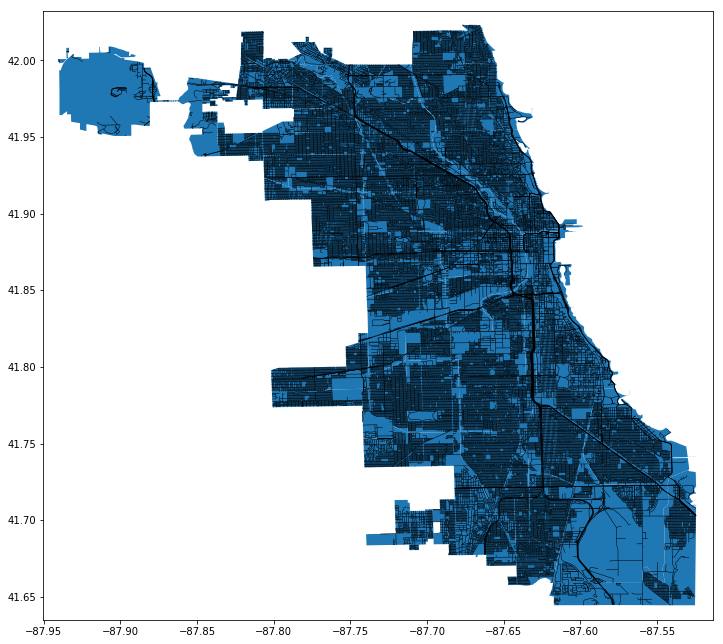

In [16]:
fig, ax = plt.subplots(figsize=(12,12))

lc = matplotlib.collections.LineCollection(open_cp.plot.lines_from_geometry(chicago.geometry),
    color="black", linewidth=0.5)
ax.add_collection(lc)

patches = open_cp.plot.patches_from_geometry(areas.geometry,
    fc="blue", ec="none", alpha=0.5, zorder=5)
ax.add_collection(matplotlib.collections.PatchCollection(patches))
    
ax.set_aspect(1.0)

xmin, ymin, xmax, ymax = areas.total_bounds
xd, yd = xmax - xmin, ymax - ymin
ax.set(xlim=[xmin - xd/40, xmax + xd/40], ylim=[ymin - yd/40, ymax + yd/40])
None

In [19]:
chicago = chicago.to_crs({"init":"epsg:3528"})

# Projecting to nearest line segment

![Diagram](image1.png)

In the above diagram, we wish to find $t$.  We know that $v = b-a$, that $u\cdot v=0$, and that $x-a = tv + u$.  Thus
$$ (x-a) \cdot v = t\|v\|^2 \quad\implies\quad t = \|v\|^{-2} (x-a)\cdot v. $$

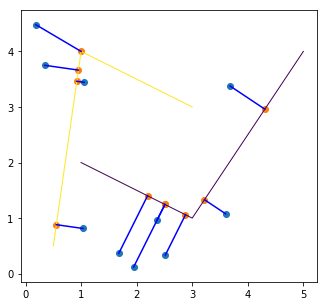

In [5]:
import shapely

lines = [
    ((1,2), (3,1), (5,4)),
    ((0.5, 0.5), (1,4), (3,3))
    ]
lines_shapely = [shapely.geometry.LineString(li) for li in lines]
points = np.random.random((10,2)) * 5

projs = []
for pt in points:
    best = open_cp.geometry.project_point_to_lines(pt, lines)
    projs.append(best)
projs = np.asarray(projs)    

fig, ax = plt.subplots(figsize=(8,5))
frame = gpd.GeoDataFrame()
frame.geometry = lines_shapely
frame.plot(ax=ax)
ax.scatter(points[:,0], points[:,1])
ax.scatter(projs[:,0], projs[:,1])
for pt, ppt in zip(points, projs):
    ax.plot([pt[0],ppt[0]], [pt[1],ppt[1]], color="blue")
ax.set_aspect(1)

In [8]:
projs2 = []
for pt in points:
    best = open_cp.geometry.project_point_to_lines_shapely(pt, lines_shapely)
    projs2.append(best)
projs2 = np.asarray(projs)    

np.testing.assert_allclose(projs, projs2)

In [10]:
pp = open_cp.geometry.ProjectPointLinesRTree(lines)
projs3 = []
for pt in points:
    best = pp.project_point(pt)
    projs3.append(best)
projs3 = np.asarray(projs)    

np.testing.assert_allclose(projs, projs3)

# Case study

- "chicago_all_old.csv" is an old file, now no longer available, which has "correctly" geo-coded data.  As such, it makes an interesting test for us.
- Current data is already (pretty much) projected to the center of streets.

In [11]:
import open_cp.sources.chicago
points = open_cp.sources.chicago.load(os.path.join(datadir, "chicago_all_old.csv"), {"BURGLARY"}, type="all")
points.time_range

(numpy.datetime64('2001-01-01T00:01:00.000'),
 numpy.datetime64('2014-05-24T22:30:00.000'))

In [45]:
# Convert to a sequence of lines
lines = []
for geo in chicago.geometry:
    try:
        lines.append(list(geo.coords))
    except:
        for x in geo:
            lines.append(list(x.coords))

In [46]:
out = []
for pt in points.coords.T:
    best = open_cp.geometry.project_point_to_lines(pt, lines)
    out.append(best)

KeyboardInterrupt: 

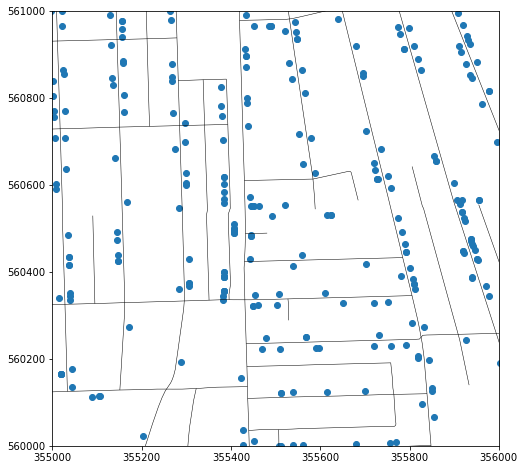

In [22]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(points.xcoords, points.ycoords)
lc = matplotlib.collections.LineCollection(open_cp.plot.lines_from_geometry(chicago.geometry),
    color="black", linewidth=0.5)
ax.add_collection(lc)

xrange = [355000, 356000]
yrange = [560000, 561000]
ax.set(xlim=xrange, ylim=yrange)
None